In [21]:
# Importing useful libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [22]:
# Initialising useful parameters
BLUR = 21
CANNY_THRESH_1 = 10
CANNY_THRESH_2 = 200
MASK_DILATE_ITER = 10
MASK_ERODE_ITER = 10
MASK_COLOR = (0.0,0.0,1.0) # In BGR format

In [48]:
imgPath = "D:\Wobot\Broccoli\\New folder\Rot12.jpg"
# imgPath = "D:\Wobot\Broccoli\Drive\orange_good.jpg"
image = cv2.imread(imgPath)

In [49]:
new_image = np.zeros(image.shape, image.dtype)
alpha = 1.2 # Simple contrast control
beta = 20 # Simple brightness control

In [50]:
# Changing the contrast and brightness for the newly created image for exaggerating the differences in colors in the image
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        for c in range(image.shape[2]):
            new_image[y,x,c] = np.clip(alpha*image[y,x,c] + beta, 0, 255)

In [51]:
# plt.subplot(122),plt.imshow(new_image),plt.title('median')

(<matplotlib.axes._subplots.AxesSubplot at 0x1ecff9241d0>,
 Text(0.5, 1.0, 'median'))

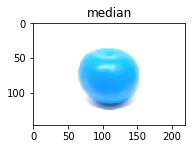

In [52]:
# Image Smoothing
# Image Averaging
img=new_image
kernel = np.ones((3,3),np.float32)/9
dst = cv2.filter2D(img,-1,kernel)
# Image Blurring
img = cv2.medianBlur(img,5)
plt.subplot(122),plt.imshow(img),plt.title('median')

In [53]:
# Edge Detection
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
# Morphological Transformation
edges = cv2.dilate(edges, None)
edges = cv2.erode(edges, None)

In [54]:
# Finding contours
contour_info = []
_, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for c in contours:
    contour_info.append((
        c,
        cv2.isContourConvex(c),
        cv2.contourArea(c),
    ))


contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
max_contour = contour_info[0]

In [55]:
# Create empty mask, draw filled polygon on it corresponding to largest contour
# Mask is black, polygon is white
mask = np.zeros(edges.shape)
cv2.fillConvexPoly(mask, max_contour[0], (255)) # Removing image background

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
#Smooth mask, then blur it
mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
mask_stack = np.dstack([mask]*3)

In [57]:
# Blend masked img into MASK_COLOR background
mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices,
img = img.astype('float32') / 255.0                 #  for easy blending
masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR) # Blend
masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit

In [58]:
# Masking for fungus
hsv = cv2.cvtColor(masked, cv2.COLOR_BGR2HSV)
lower_white = np.array([10,10,0], dtype=np.uint8)
upper_white = np.array([35,40,255], dtype=np.uint8)
mask = cv2.inRange(hsv, lower_white, upper_white)
res = cv2.bitwise_and(masked,masked, mask= mask)

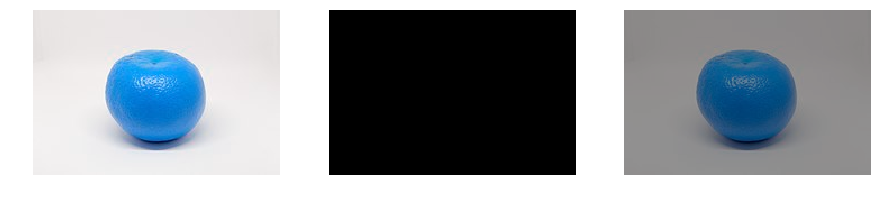

In [59]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')

image = cv2.imread(imgPath)
#Show original image of same shape as of edges_pz or mask. Arguments should be image not its path.

axarr[0].imshow(image)
#Show the maks or edges_pz in your case
axarr[1].imshow(res)

#Show the image with combined mask and the original image, the shape of both image and mask should be same.
axarr[2].imshow(image)
axarr[2].imshow(res, alpha=0.4)

In [60]:
if mask.any() > 0:
    print("FUNGUS FOUND")
else:
    print("FUNGUS NOT FOUND")

FUNGUS NOT FOUND
